In [157]:
import random
from numpy import random as rnd
import matplotlib.pyplot as plt
import numpy as np
import pytz
import datetime
import os
import pandas as pd
import itertools
import seaborn as sns

STAY = 0
LEAVE = 1

OFF = 0
ON = 1

ITI_state = {"patch" : OFF , "rewindex" : -1}


In [203]:
# patchForagingAgents.py

class Agent:
    """
    General class for Q learning agents
    """
    def __init__(self,nRewSizes,integration_dim,decision_type,rewsizes,beta = 1,epsilon = .9,baseline_epsilon = 0.1 ):
        self.Q = [np.zeros(2),np.zeros((nRewSizes,2,integration_dim))]
        self.epsilon0 = epsilon
        self.epsilon = epsilon # proportion of exploration in egreedy
        self.baseline_epsilon = baseline_epsilon # baseline exploration for egreedy
        self.beta = beta
        self.lr = 0.1 # learning rate
        self.discount = .5 #.9
        self.decision_type = decision_type # "egreedy" or "softmax"
        self.nRewSizes = nRewSizes
        self.rewsizes = rewsizes
        self.test1 = {1 : [] , 2 : [] , 4 : []}
        self.test2 = {1 : [] , 2 : [] , 4 : []}

    def select_action(self,rewsize_index,rew_int,patch):
        """
            Agent chooses an action
            Returns: new action
        """
        if self.decision_type == "egreedy":
            if rnd.random() > self.epsilon:
                return self.greedy_action(rewsize_index,rew_int,patch)
            else:
                return self.random_action()
        elif self.decision_type == "softmax":
            if patch == ON:
                Q_stay = self.Q[ON][rewsize_index,STAY,rew_int]
                Q_leave = self.Q[ON][rewsize_index,LEAVE,rew_int]
            else:
                Q_stay = self.Q[OFF][STAY]
                Q_leave = self.Q[OFF][LEAVE]
            p_stay = (1 + np.exp(-self.beta * (Q_stay - Q_leave))) ** (-1)
            return STAY if rnd.rand() < p_stay else LEAVE
        else:
            raise ValueError("Please use \"egreedy\" or \"softmax\" as decision type")

    def random_action(self):
        """
            Agent takes a random action
        """
        return STAY if random.random() < 0.5 else LEAVE

    def greedy_action(self,rewsize_index,rew_int,patch):
        """
            Agent takes most rewarding action in current state according to Q table
        """
        if patch == ON:
            Q_stay = self.Q[ON][rewsize_index,STAY,rew_int]
            Q_leave = self.Q[ON][rewsize_index,LEAVE,rew_int]
        else:
            Q_stay = self.Q[OFF][STAY]
            Q_leave = self.Q[OFF][LEAVE]
        if Q_stay > Q_leave:
            return STAY
        elif Q_leave > Q_stay:
            return LEAVE
        return STAY if random.random() < 0.5 else LEAVE # Rewards are equal, take random action

    def update(self,old_rewsize_index, old_rew_int, patch_old, 
                    new_rewsize_index, new_rew_int, patch_new, 
                    action, reward):
        """
            Update agent Q-table based on experience
            Arguments: old_state,new_state,action,reward
        """
        if patch_old == ON and patch_old == ON: 
            q_old = self.Q[ON][old_rewsize_index,action,old_rew_int] # Old Q-table value
            future_action = self.greedy_action(new_rewsize_index,new_rew_int,ON) # Select next best action
            EV_new = self.Q[ON][new_rewsize_index,future_action,new_rew_int]
            rpe = reward + self.discount * EV_new - q_old
            self.Q[ON][old_rewsize_index,action,old_rew_int] += self.lr * rpe
        
        elif patch_old == ON and patch_new == OFF:
            q_old = self.Q[ON][old_rewsize_index,action,old_rew_int] # Old Q-table value
            future_action = self.greedy_action(new_rewsize_index,new_rew_int,OFF)
            EV_new = self.Q[OFF][future_action]
            rpe = reward + self.discount * EV_new - q_old
            self.Q[ON][old_rewsize_index,action,old_rew_int] += self.lr * rpe
        
        elif patch_old == OFF and patch_new == ON:
            q_old = self.Q[OFF][action]
            future_action = self.greedy_action(new_rewsize_index,new_rew_int,ON) # Select next best action
            EV_new = self.Q[ON][new_rewsize_index,future_action,new_rew_int]
            rpe = reward + self.discount * EV_new - q_old
            self.Q[OFF][action] += self.lr * rpe 
            
        elif patch_old == OFF and patch_new == OFF:
            q_old = self.Q[OFF][action]
            future_action = self.greedy_action(new_rewsize_index,new_rew_int,OFF)
            EV_new = self.Q[OFF][future_action]
            rpe = reward + self.discount * EV_new - q_old
            self.Q[OFF][action] += self.lr * rpe  
        
        return rpe 

class Model1Agent(Agent):
    """
        rew integration is a function of time
    """
    def __init__(self,nRewSizes,decision_type,nTimestates,rewsizes,
                                              beta = 1,epsilon = .5,baseline_epsilon = .1):
        integration_dim = nTimestates
        super().__init__(nRewSizes,integration_dim,decision_type,rewsizes,
                                              beta = beta,epsilon = epsilon,baseline_epsilon = baseline_epsilon)

    def integrate(self,env_state):
        if env_state["patch"] == ON:
            return env_state["t"]
        else: 
            return -1

class Model2Agent(Agent):
    """
        rew integration is a function of time since previous reward, reward size
    """
    def __init__(self,nRewSizes,decision_type,nTimestates,rewsizes,
                                              beta = 1,epsilon = .5,baseline_epsilon = .1):
        integration_dim = nTimestates
        super().__init__(nRewSizes,integration_dim,decision_type,rewsizes,
                                              beta = beta,epsilon = epsilon,baseline_epsilon = baseline_epsilon)

    def integrate(self,env_state):
        if env_state["patch"] == ON:
            time_since = list(reversed(env_state["rews"])).index(env_state["rewsize"])
            return time_since
        else: 
            return -1

class Model3Agent(Agent):
    """
        rew integration is a function of total rewards received over time, reward size
    """
    def __init__(self,nRewSizes,decision_type,nTimestates,rewsizes,
                                            a = 2,b = 1,
                                            beta = 1,epsilon = .5,baseline_epsilon = .1):
        integration_dim = 2 * nTimestates * 2 # so we never go negative in Q indexing
        super().__init__(nRewSizes,integration_dim,decision_type,rewsizes,
                                   beta=beta,epsilon = epsilon,baseline_epsilon = baseline_epsilon)
        self.a = a
        self.b = b
        self.integration_baseline = integration_dim / 2
#         print(self.integration_baseline)

    def integrate(self,env_state):
        if env_state["patch"] == ON:
            t = env_state["t"]
            rew_int = self.a * sum(env_state["rews"][:(t+1)])/env_state["rewsize"] - self.b * t + self.integration_baseline
            return int(rew_int)
        else:
            return -1


In [204]:
# patchyEnvironment.py

# Methods to draw from discrete expo distributions for Patch Environment
def cdf(x,N0):
    A = -.125
    return 1+ N0 * 1/A * np.exp(A*x) - N0/A
def pdf(this_cdf):
    this_pdf = []
    for t in range(1,len(this_cdf)):
        this_pdf.append(this_cdf[t]-this_cdf[t-1])
    this_pdf.insert(0,1) # add that first reward
    return this_pdf

def generate_pdfs(N0):
    pdfs = dict()
    for n0 in N0:
        x = list(map(cdf,list(range(50)),np.full(50,n0)))
        pdfs[n0] = pdf(x)
    return pdfs

# virtual patch environment
class PatchEnvironment():
    """
        Virtual foraging environment
        This only does two things:
            1. Return rewards on probabilistic or deterministic reward schedules
            2. Return patch ON state or patch OFF state
            3. Does need to keep track of time for logging purposes?
            3.5. Log output data as this is what is going to match what we observe?
    """
    def __init__(self,rew_system = 'probabilistic',nTimestates = 50,ITI_penalty = 3,timecost = .2):
        self.rew_system = rew_system
        self.nTimestates = nTimestates
        self.ITI_penalty = ITI_penalty
        self.N0 = [.5, .25, .125]
        self.pdfs = generate_pdfs(self.N0)
        self.rewsizes = [1, 2, 4]
        self.state = ITI_state
        self.timecost = timecost

    def execute_action(self, action, probe_trial = {}):
        """
            Environment changes state, returns reward based on agent action
            Arguments: action {STAY or LEAVE}
            Returns: new state, reward
        """
        if action == STAY and (self.state["patch"] == ON) and (self.state["t"] < self.nTimestates - 1):
            self.state["t"] += 1 # increment time on patch
            rew = self.state["rews"][self.state["t"]] - self.timecost # give reward acc to current schedule
        elif action == LEAVE and self.state["patch"] == ON:
            self.state = ITI_state
            rew = - self.ITI_penalty - self.timecost
        elif action == STAY and self.state["patch"] == OFF: # don't change state
            rew = - self.timecost
        else : # action == LEAVE and self.state["patch"] == OFF
            self.new_patch(probe_trial = probe_trial) # this changes the env state
            rew = self.state["rews"][self.state["t"]] -self.ITI_penalty - self.timecost # deliver the first reward

        return rew

    def new_patch(self,probe_trial = {}):
        # normal random trial
        if len(probe_trial) == 0:
            curr_rews = np.zeros(self.nTimestates)
            curr_rewsize = rnd.choice(self.rewsizes)
            curr_rewfreq = rnd.choice(self.N0)
            if self.rew_system == 'deterministic':
                curr_rews[[0,4,16]] = curr_rewsize
            if self.rew_system == 'probabilistic':
                curr_rewlocs = np.where(rnd.random(50) - self.pdfs[curr_rewfreq] < 0)[0].tolist()
                curr_rews[curr_rewlocs] = curr_rewsize
            curr_rewindex = self.rewsizes.index(curr_rewsize)
            self.state = {"patch" : ON , "rewsize" : curr_rewsize,"rewindex" : curr_rewindex, 
                               "n0" : curr_rewfreq , "rews" : curr_rews,"t" : 0}
        else:
            self.state = probe_trial # use a probe trial


In [208]:
# QLearner.py

class RLInterface():
    """
        Bring together an agent and an environment and THROW DOWN
        Methods: step, run_trials, various visualizations
    """
    def __init__(self,agent,environment):
        self.agent = agent
        self.env = environment

    def step(self,probe_trial = {}):
        old_state = self.env.state.copy()
        old_rew_index = old_state["rewindex"] 
        old_rew_int = self.agent.integrate(old_state) # internalize old env state
        old_patch = old_state["patch"]
        
        action = self.agent.select_action(old_rew_index,old_rew_int,env.state["patch"]) # agent selects action
        
        rew = self.env.execute_action(action,probe_trial) # execute agent action into the environment
        new_state = self.env.state.copy()
        new_rew_index = self.env.state["rewindex"]
        new_rew_int = self.agent.integrate(new_state) # internalize new env state
        new_patch = new_state["patch"]
        
        rpe = self.agent.update(old_rew_index, old_rew_int,old_patch,
                                new_rew_index, new_rew_int,new_patch, action, rew) # update Q
        if self.env.state["patch"] == ON:
            value = self.agent.Q[ON][old_rew_index,STAY,old_rew_int]
        elif self.env.state["patch"] == OFF:
            value = self.agent.Q[OFF][LEAVE]

        return action,rew,rpe,value

    def run_trials(self,nTrials,epsilon_decay = 0,probe_specs = []):
        actions = []
        self.prts = {1:[],2:[],4:[]} # Patch residence times divided by reward size
        self.rew_locs = {1:[],2:[],4:[]} # Reward locations for heatmap visualization
        self.prts_plus = {1:{.125:[],.25:[],.5:[]}, # Patch residence times divided by reward size and N0
                          2:{.125:[],.25:[],.5:[]},
                          4:{.125:[],.25:[],.5:[]}}
        self.rews = [] # Flat vector of reward received for efficiency visualization
        self.rpes = {1:[],2:[],4:[]} # for rpe heatmap visualization
        self.values = {1:[],2:[],4:[]} # for value heatmap visualization
        self.rews_trialed = {1:[],2:[],4:[]} # for heatmap visualization 

        # run trials with no probe trials
        if len(probe_specs) == 0:
            for iTrial in range(nTrials):
                # Start with patch off
                while env.state["patch"] == OFF:
                    action,rew,rpe,value = self.step()
                    self.rews.append(rew)
                
                # initialize trial record keeping datastructures
                self.curr_rew = self.env.state["rewsize"]
                self.curr_freq = self.env.state["n0"]
                self.rew_locs[self.curr_rew].append(self.env.state["rews"])
                self.curr_prt = 0
                curr_rpes = []
                curr_rew_rec = []
                curr_values = []
                
                while env.state["patch"] == ON: # now behave on patch
                    action,rew,rpe,value = self.step()
                    curr_rew_rec.append(rew)
                    actions.append(action)
                    curr_rpes.append(rpe)
                    curr_values.append(value)
                    self.rews.append(rew) 
                    self.curr_prt += 1
                    if self.curr_prt > 50:
                        print ('hey')
                
                # record data after leaving
                self.rews_trialed[self.curr_rew].append(curr_rew_rec)
                self.rpes[self.curr_rew].append(curr_rpes)
                self.values[self.curr_rew].append(curr_values)
                self.prts[self.curr_rew].append(self.curr_prt)
                self.prts_plus[self.curr_rew][self.curr_freq].append(self.curr_prt)
                # update epsilon for egreedy
                self.agent.epsilon = self.agent.epsilon0 * np.e**(-iTrial/epsilon_decay) + self.agent.baseline_epsilon

    def show_qtable(self):
        """
            A visualization method to analyze how the agent is making decisions
        """
        plt.subplots_adjust(hspace = 15,wspace = .5)
        plt.suptitle('Agent Q Table',x=.5,y=1.05)
        plt.subplot(1,2,1)
        plt.title('Patch ON STAY Q table')
        sns.heatmap(self.agent.Q[ON][:,STAY,:])
        plt.subplot(1,2,2)
        plt.title('Patch ON LEAVE Q table')
        sns.heatmap(self.agent.Q[ON][:,LEAVE,:])
        plt.show()

    def plot_percent_stay(self,decisions):
        """
            Just visualize the proportion of stay decisions agent is making on the patch
        """
        percent = [1 - sum(decisions[0:i])/i for i in range(1,len(decisions))]
        plt.figure()
        plt.title('Percent of STAY choice on patch over time')
        plt.ylim([0,1])
        plt.plot(percent)

    def plot_prts(self,resolution):
        """
            Visualize smoothed PRTs over learning, separated by patch type
            Use this to determine around where behavior stabilizes
        """
        plt.figure()
        for patch in self.prts.keys():
            coords = list(range(0,len(self.prts[patch])-resolution,resolution))
            smoothened = [np.mean(self.prts[patch][coords[i]:coords[i+1]]) for i in range(len(coords)-1)]
            plt.plot(smoothened,label = str(str(patch) + ' uL'))
        plt.legend()
        plt.ylabel('Avg Patch Residence Time')
        plt.xlabel('Time over training')
        plt.title('Patch-Separated Evolution of PRTs over Training')

    def plot_rewrate(self,resolution,agent_type,irange = []):
        """
            Visualize smoothed rewrate over course of learning
            Use this to determine around where behavior stabilizes and how efficient the algorithm is
        """
        plt.figure()
        # print(irange)
        if len(irange) == 0:
            coords = list(range(0,len(self.rews)-resolution,resolution))
        else:
            coords = list(range(irange[0],irange[1],resolution))
            # print(coords)
        smoothened = [np.mean(self.rews[coords[i]:coords[i+1]]) for i in range(len(coords)-1)]
        plt.plot(smoothened)
        plt.ylabel('Avg Rew/sec')
        plt.ylim([0,.6])
        plt.xlabel('Time over training')
        plt.title('Rew/sec over Training for ' + agent_type + ' Agent')
        if len(irange) == 0:
            print("Mean:",np.mean(self.rews))
            print("Std:",np.std(self.rews))
        else:
            print("Mean:",np.mean(self.rews[irange[0] : irange[1]]))
            print("Std:",np.std(self.rews[irange[0] : irange[1]]))

    def prt_bars(self,start):
        """
            Visualize proportion of stay decisions agent makes on patch, separated by patch type
            Input start parameter, where we start analysis based on convergence after plot_prts analysis
        """
        data = []
        lengths = []
        for patch in self.prts.keys():
            print(patch)
            data.append(self.prts[patch])
            lengths.append(len(np.array(self.prts[patch])))
        min_len = min(lengths)
        array_prts = np.array([data[i][start:min_len] for i in range(len(data))]).T
        self.patch_df = pd.DataFrame(array_prts,columns = ['Sm','Md','Lg'])

        plt.figure()
        ax = sns.barplot(data = self.patch_df,palette = [(0,0,0),(.5,1,1),(0,0,1)],edgecolor=".2")
        plt.xlabel('Rew Size (uL)')
        plt.ylabel('Mean PRT (sec)')
        plt.title('PRT by Reward Size')
        plt.show()

    def prt_hist(self,start):
        """
            Input start parameter, where we start analysis based on convergence after plot_prts analysis
            Basically a more detailed visualization of the prt_bars
        """
        data = []
        lengths = []
        for patch in self.prts.keys():
            data.append(self.prts[patch])
            lengths.append(len(np.array(self.prts[patch])))
        min_len = min(lengths)
        array_prts = np.array([data[i][start:min_len] for i in range(len(data))]).T
        array_prts = array_prts + rnd.normal(0,.3,array_prts.shape)
        self.patch_df = pd.DataFrame(array_prts,columns = ['Sm','Md','Lg'])

        plt.figure(figsize = [5,15])
        plt.subplot(3,1,1)
        plt.title('1 uL Rewsize')
        sns.distplot(self.patch_df["Sm"], color=(0,0,0), hist=False, rug=False)
        plt.subplot(3,1,2)
        plt.title('2 uL Rewsize')
        sns.distplot(self.patch_df["Md"], color=(.5,1,1), hist=False, rug=False)
        plt.subplot(3,1,3)
        plt.title('4 uL Rewsize')
        sns.distplot(self.patch_df["Lg"], color = (0,0,1),hist=False, rug=False)

        # plt.xlabel('Rew Size (uL)')
        plt.suptitle('PRT Distribution by Reward Size')
        plt.show()

    def prt_plus_bars(self,start):
        """
            Visualize mean PRT separated by reward size and frequency
            Input start parameter, where we start analysis based on convergence after plot_prts analysis
        """
        data = []
        lengths = []
        for rew_size in self.prts_plus.keys():
            for rew_freq in self.prts_plus[rew_size].keys():
                data.append(self.prts_plus[rew_size][rew_freq])
                lengths.append(len(self.prts_plus[rew_size][rew_freq]))
        min_len = min(lengths)
        array_prts = np.array([data[i][start:min_len] for i in range(len(data))]).T
        self.patch_plus_df = pd.DataFrame(array_prts,columns = ['1uL Lo','1uL Md','1uL Hi','2uL Lo','2uL Md','2uL Hi','4uL Lo','4uL Md','4uL Hi'])

        colors = [(.5,.5,.5),(.3,.3,.3),(0,0,0),(.9,1,1),(.7,1,1),(.5,1,1),(.5,.5,1),(.3,.3,1),(0,0,1)]
        plt.figure()
        ax = sns.barplot(data = self.patch_plus_df,palette = colors,edgecolor=".2")
        plt.xlabel('Rew Size (uL)')
        plt.ylabel('Mean PRT (sec)')
        plt.title('PRT by Reward Size and Frequency')
        plt.show()

    def mk_timecourse(self):
        """
            Convert PRTs into 'trial timecourses', binary vectors 0 if we have left patch, 1 if we are still on
        """
        data = self.prts
        num_timesteps = 51

        self.timecourses = dict()
        for patch in data.keys(): # could make this a double list comp but i still hold some mercy in my heart
#             for prt in data[patch]:
#                 print(prt)
            if max(data[patch]) > num_timesteps:
                print(max(data[patch]))
            self.timecourses[patch] = np.array([list(np.ones(prt)) + list(np.zeros(num_timesteps-prt)) for prt in data[patch]])

    def plot_survival(self):
        """
            Plot timecourses in terms of survival curves separated by patch
        """
        plt.figure()
        colors = {1:(0,0,0),2:(.5,1,1),4:(0,0,1)}
        for patch in self.timecourses.keys():
            survival = np.sum(self.timecourses[patch],axis = 0)/self.timecourses[patch].shape[0]
            plt.plot(survival[:12],label = str(str(patch) + ' uL'),color = colors[patch])
        plt.legend()
        plt.title('Patch Survival Curve')
        plt.xlabel('Time on Patch (seconds)')
        plt.ylabel('% Survival')
        plt.show()

    def percent_hmap(self,timeRange,trialRange):
        """
            Visualize percent stay over time on patch separated by patch type

            Clean this up
        """
        counter = 1

        plt.figure(figsize = [5,15])
        for patch in [1,2,4]:
            rews = np.array(self.rew_locs[patch])/patch
            cumulative_rews = rews.copy()
            for iTime in range(timeRange[1]):
                cumulative_rews[:,iTime] = np.sum(rews[:,:iTime+1],axis = 1)

            max_rew = int(np.max(cumulative_rews[trialRange[0]:trialRange[1],timeRange[0]:timeRange[1]]))

            hmap_num = np.zeros((max_rew,timeRange[1]))
            hmap_denom = np.zeros((max_rew,timeRange[1]))
            for trial in range(trialRange[0],trialRange[1]):
                for time in range(timeRange[0],timeRange[1]):
                    cumulative_rew = int(cumulative_rews[trial,time])
                    hmap_num[cumulative_rew-1,time] += self.timecourses[patch][trial,time]
                    hmap_denom[cumulative_rew-1,time] += 1
            # display(hmap_denom)
            hmap = np.divide(hmap_num,hmap_denom,where = hmap_denom>0)
            hmap[np.where(hmap > 1)[0]] = 0
            plt.subplot(3,1,counter)
            plt.title(str(str(patch) + 'uL Rew Size'))
            ax = sns.heatmap(hmap)
            ax.invert_yaxis()
            plt.xlabel('Time on patch (sec)')
            plt.ylabel('Rewards Received')
            counter += 1
        plt.suptitle('Heatmap of patch stay percentage')
        plt.show()

    def rpe_hmap(self,timeRange,trialRange):
        """
            Visualize history-dependent RPE over time separated by patch type
        """
        counter = 1
        plt.figure(figsize = [5,15])
        for patch in [1,2,4]:
            rews = np.array(self.rew_locs[patch])/patch
            cumulative_rews = rews.copy()
            for iTime in range(timeRange[1]):
                cumulative_rews[:,iTime] = np.sum(rews[:,:iTime+1],axis = 1)

            max_rew = int(np.max(cumulative_rews[trialRange[0]:trialRange[1],timeRange[0]:timeRange[1]]))

            hmap_num = np.zeros((max_rew,timeRange[1]))
            hmap_denom = np.zeros((max_rew,timeRange[1]))
            for trial in range(trialRange[0],trialRange[1]):
                for time in range(min( len(self.rpes[patch][trial])-1,timeRange[1])):
                    cumulative_rew = int(cumulative_rews[trial,time])

                    if self.rews_trialed[patch][trial][time] > 0:
                        hmap_num[cumulative_rew-1,time] += self.rpes[patch][trial][time]
                        hmap_denom[cumulative_rew-1,time] += 1
            # display(hmap_denom)
            hmap = np.divide(hmap_num,hmap_denom,where = hmap_denom>0)
            plt.subplot(3,1,counter)
            plt.title(str(str(patch) + 'uL Rew Size'))
            ax = sns.heatmap(hmap)
            ax.invert_yaxis()
            plt.xlabel('Time on patch (sec)')
            plt.ylabel('Rewards Received')
            counter += 1
        plt.suptitle('RPE Heatmap')
        plt.show()

    def value_hmap(self,timeRange,trialRange):
        """
            Visualize history-dependent value representation over time sep by patch type
        """
        counter = 1
        plt.figure(figsize = [5,15])
        for patch in [1,2,4]:
            rews = np.array(self.rew_locs[patch])/patch
            cumulative_rews = rews.copy()
            for iTime in range(timeRange[1]):
                cumulative_rews[:,iTime] = np.sum(rews[:,:iTime+1],axis = 1)

            max_rew = int(np.max(cumulative_rews[trialRange[0]:trialRange[1],timeRange[0]:timeRange[1]]))

            hmap_num = np.zeros((max_rew,timeRange[1]))
            hmap_denom = np.zeros((max_rew,timeRange[1]))
            for trial in range(trialRange[0],trialRange[1]):
                for time in range(min( len(self.values[patch][trial])-1,timeRange[1])):
                    cumulative_rew = int(cumulative_rews[trial,time])

                    if self.rews_trialed[patch][trial][time] > 0:
                        hmap_num[cumulative_rew-1,time] += self.values[patch][trial][time]
                        # if self.values[patch][trial][time] > 4:
                        #     print(self.values[patch][trial][time])
                        hmap_denom[cumulative_rew-1,time] += 1
            # display(hmap_denom)
            hmap = np.divide(hmap_num,hmap_denom,where = hmap_denom>0)
            plt.subplot(3,1,counter)
            plt.title(str(str(patch) + 'uL Rew Size'))
            ax = sns.heatmap(hmap)
            ax.invert_yaxis()
            plt.xlabel('Time on patch (sec)')
            plt.ylabel('Rewards Received')
            counter += 1
        plt.suptitle('Value Heatmap')
        plt.show()

    def bs_hmap(self,timeRange,trialRange):
        """
            Plot optimistic belief state according to markov model with reward integration data
        """


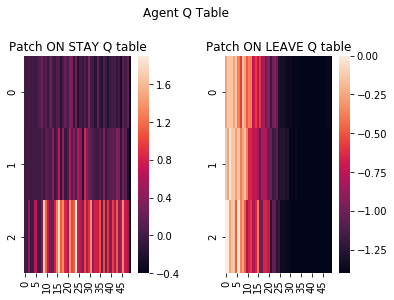

Mean: 0.15269069189220083
Std: 1.2171134054068016
1
2
4


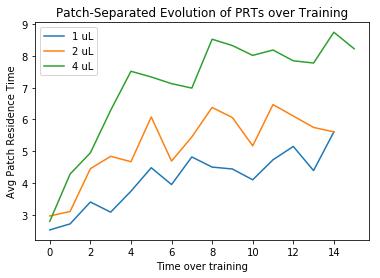

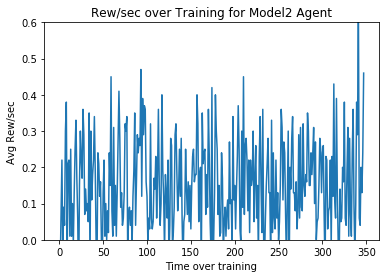

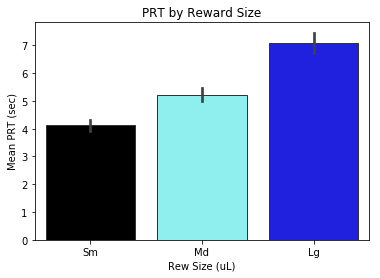

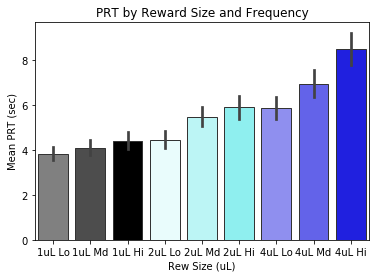

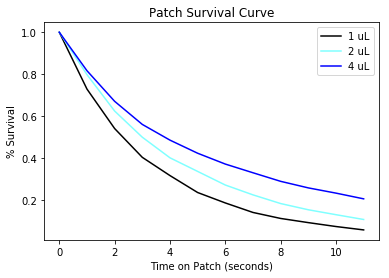

In [210]:
# runner.py

# run RL interface
env = PatchEnvironment('probabilistic',nTimestates = 50,ITI_penalty = 1,timecost = .2)

agent_type = 'Model2' # sys.argv[1]

if agent_type == 'Model1':
    agent = Model1Agent(len(env.rewsizes),"softmax",env.nTimestates,env.rewsizes,beta = .9)
if agent_type == 'Model2':
    agent = Model2Agent(len(env.rewsizes),"softmax",env.nTimestates,env.rewsizes,beta = 1)
if agent_type == 'Model3': # model 3 biases towards longer prts... why?
    agent = Model3Agent(len(env.rewsizes),"softmax",env.nTimestates,env.rewsizes,b = 1,a = 3,beta = 1.5)

rl = RLInterface(agent,env)

# should add something so epsilon never goes to exactly 0
decisions = rl.run_trials(5000,epsilon_decay = 3000)

# # visualization
rl.show_qtable()
# rl.plot_percent_stay(decisions)
rl.plot_prts(100)

# assess agent efficiency
rl.plot_rewrate(100,agent_type)

# mean PRT analysis
rl.prt_bars(10)
# rl.prt_hist(10000)
rl.prt_plus_bars(10)
# print(np.mean(rl.prts_plus[1][.125]))
# print(np.mean(rl.prts_plus[1][.25]))
# print(np.mean(rl.prts_plus[1][.5]))

# timecourse analysis
rl.mk_timecourse()
rl.plot_survival()

# # make a function for plotting color density as percent patch residence
# rl.percent_hmap([0,10],[20000,30000])

# # heatmap rpes
# # from behavioral heatmap, how can we evaluate level of exploration vs exploitation in animal behavioral model
# rl.rpe_hmap([0,10],[20000,30000])

# # heatmap of value
# rl.value_hmap([0,10],[20000,30000])

# plt.figure()
# # sns.distplot(rl.agent.qdiff_test)
# # plt.title('distribution of q value differences')
# plt.show()


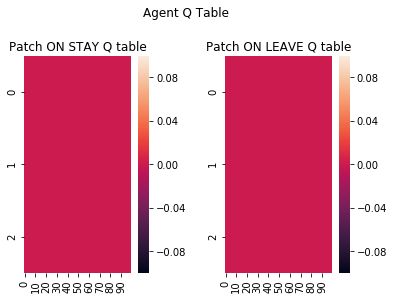

{'rewsize': 2, 'rewindex': 1, 'n0': 0.125, 'rews': array([0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 't': 1}
2 1
{'rewsize': 2, 'rewindex': 1, 'n0': 0.125, 'rews': array([0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 't': 2}
2 2
{'rewsize': 2, 'rewindex': 1, 'n0': 0.125, 'rews': array([0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 't': 3}
2 3
{'rewsize': 1, 'rewindex': 0, 'n0': 0.25, 'rews': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0.

In [103]:
env = PatchEnvironment('probabilistic',nTimestates = 50,ITI_penalty = 3)

agent_type = 'Model3' # sys.argv[1]

if agent_type == 'Model3':
    agent = Model3Agent(len(env.rewsizes),"softmax",env.nTimestates,env.rewsizes,beta = .8)

rl = RLInterface(agent,env)
env.new_patch()
rl.show_qtable()
for i in range(15):
    rl.step()
    t = rl.env.state['t']
    print(rl.env.state)
    rew_int = rl.agent.a * sum(rl.env.state["rews"][:(t+1)]) - rl.agent.b * t + 50
    print(rl.env.state['rewsize'],rl.env.state['t'])
#     rl.show_qtable()

In [193]:
rl.agent.Q[OFF][LEAVE]

1.105983374447946

In [196]:
(1 + 2 + 4)/3 * .9 - .2

1.9000000000000001